# Projet: Débordement d'égouts
## Rapport équipe 9 - A19
#### Noboru Yoshida - Mehdi Chaid - Mathieu Giroux-Huppé - Maxime Gosselin
#### 20 Décembre 2019

## Table des matières

1. [Objectif](#objectives)  
    1. [Installation des librairies](#librairies) 
2. [Méthode choisie](#chosen_method)
3. [Traitement des données](#data_processing)  
    1. [Chargement des données des ouvrages](#data_processing_ouvrages) 
    2. [Chargement des données de surverse](#data_processing_surverse)  
    3. [Chargement des données de précipitation](#data_processing_precipitation)
    4. [Jointure des Dataframes](#data_processing_join)
    5. [Standardization et OneHot des colonnes](#data_processing_std_oh)
    6. [Création de l'ensemble de validation](#data_processing_validation)
4. [Sélection de modèles](#model-selection)
    1. [Régression logistique](#logistic-reg)
    2. [Classification bayésienne naive](#naive-bayes)
    3. [Forêt aléatoire](#random-forest)
    4. [Séparateur à vaste marge](#svm)
5. [Améliorations possibles](#possible-improvements)

<a id="objectives"></a>

## 1. Objectif

Ce rapport vise à fournir une prédiction sur les surverses dans plusieurs ouvrages sur l'île de Montréal. Il en existe 170 réparties sur tout le bord de l'île. Dans ce travail, nous nous attarderons à la prédiction de seulement 5 d'entre-eux, soit les suivants :
- 3260-01D dans Rivière-des-Prairies
- 3350-07D dans Ahunstic
- 4240-01D dans Pointe-aux-Trembles
- 4350-01D dans le Vieux-Montréal
- 4380-01D dans Verdun

Nous avons à notre disposition 3 jeux de données qui nous aiderons à trouver une relation entre la quantité de pluie tombé et les surverses de certain ouvrages. Nous devrons alors entraîner un modèle sur les données de 2013 à 2018, puis prédire sur certaines dates de 2019. Il n'y pas de restrictions au niveau des techniques à utilisés pour le type de modèle à utiliser. Nous avons exploré quelques techniques différentes que nous allons détaillé plus en détail dans la [section 4](#model-selection).

<a id="librairies"></a>

### 1.1 Installation des librairies nécessaires

Ici nous installerons toutes les librairies nécessaires pour la bonne exécution du reste du notebook.

In [1]:
using Pkg;
Pkg.add("CSV");
Pkg.add("Random");
Pkg.add("DataStructures");
Pkg.add("BenchmarkTools");
Pkg.add("DataFrames");
Pkg.add("Statistics");
Pkg.add("Dates");
Pkg.add("Gadfly");
Pkg.add("MLBase");
Pkg.add("DecisionTree");
Pkg.add("IterTools");

using CSV, DataFrames,Distributions,DataStructures,BenchmarkTools,DecisionTree, Statistics, Dates, Gadfly, Random, MLBase, IterTools;
include("utils/precipitation.jl");

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  99.9 %0.0 %]  14.5 %============>                            ]  29.0 %43.3 %>                ]  57.8 % [=============================>           ]  72.3 %    ]  88.9 % Resolving package versions...
 Installed OffsetArrays ────── v0.11.4
 Installed FixedPointNumbers ─ v0.7.0
 Installed Measures ────────── v0.3.1
 Installed ArrayInterface ──── v2.1.0
 Installed DiffResults ─────── v1.0.1
 Installed DiffEqDiffTools ─── v1.6.0
 Installed QuadGK ──────────── v2.3.1
 Installed ForwardDiff ─────── v0.10.8
 Installed VersionParsing ──── v1.2.0
 Installed ColorTypes ──────── v0.8.1
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
  [4fba245c] ↑ ArrayInterface v2.0.0 ⇒ v2.1.0
  [3da002f7] ↑ ColorTypes v0.8.0 ⇒ v0.8.1
  [01453d9d] ↑ DiffEqDiffTools v1.

┌ Info: Recompiling stale cache file /home/maxg/.julia/compiled/v1.2/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1240
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1242
┌ Info: Recompiling stale cache file /home/maxg/.julia/compiled/v1.2/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1240


<a id="chosen_method"></a>

## 2. Méthode choisie

<a id="data_processing"></a>

## 3. Traitement des données

Cette section expliquera comment nous allons charger et nettoyer nos données afin de bâtir les DataFrames d'entraînement, de validation et de test. Chaque bloc de code sera commenté, et à l'occasion quelques tableaux et graphiques seront disponibles afin de visualiser les opérations effectuées.

<a id="data_processing_ouvrages"></a>
### 3.1 Chargement des données des ouvrages

Ici nous chargeons les données provenant du fichier <i>ouvrages-surverses.csv</i>. Il y a plusieurs colonnes dans cette table, mais nous sommes intéréssé que par 4 de ces colonnes. Pour plus de détails sur ce jeu de donnée : http://donnees.ville.montreal.qc.ca/dataset/ouvrage-surverse.

Les colonnes retenues sont structurées comme ceci : <br>
**ID_OUVRAGE** : (String) L'idendifiant unique de chacun des ouvrages <br>
**TP_Z** : (Float64) La hauteur du trop plein (m) <br>
**TP_LAT** : (Float64) La latitude du trop plein selon le système de coordonné WGS84 <br>
**TP_LNG** : (Float64) La longitude du trop plein selon le système de coordonné WGS84 <br>

In [2]:
ouvrages = CSV.read("data/ouvrages-surverses.csv");
colnames = ["N_Env", "ID_SOMA", "ID_OUVRAGE", "NOM", "SOMA_SEC", "REGION", "TP_X", "TP_Y", "TP_Z", "TP_LAT", "TP_LNG", "EMI_X", "EMI_Y", "EMI_LNG", "EMI_LAT"];
names!(ouvrages, Symbol.(colnames));
select!(ouvrages, [:ID_OUVRAGE, :TP_LAT, :TP_LNG, :TP_Z]);

#### Inputation des hauteurs de Trop-plein manquant par la moyenne des hauteurs des autres trop plein.

Nous avons choisi de remplacé les données manquantes des hauteurs des trop-plein par la moyenne de ceux-ci puisque c'est une technique assez populaire dans les sciences des données afin de ne pas trop modifié les statisques de la colonne. Pour donner un contre exemple, nous aurions pu aussi remplacer les données manquantes par 0, c'est aussi une technique assez communes, mais dans le contexte d'une hauteur de trop plein, une hauteur de 0m n'a aucun sens.

In [3]:
ouvrages.TP_Z = coalesce.(ouvrages.TP_Z, mean(ouvrages[completecases(ouvrages), :].TP_Z));
first(shuffleDf(ouvrages), 5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z
,String,Float64,Float64,Float64
1,0801-06D,45.5187,-73.533,18.66
2,3305-04D,45.6196,-73.6329,11.76
3,4260-01D,45.6308,-73.495,12.21
4,4600-03D,45.4364,-73.8226,26.42
5,3540-02D,45.4751,-73.8727,26.52


#### Visualtion des données chargées

Dans le premier graphique, on peut observer la répartion des hauteurs de trop-plein. On peut remarqué une silhouette d'une double loi normale centré en 13 et 25. Nous pouvons aussi voir nos valeurs de trop-plein manquant que nous avons imputé juste avant (la grande barre en 19). Nous pouvons donc valider que notre choix d'imputation est sensé.

Dans le second graphique, on peut observer la position de chacun des trop-pleins tout le tour de l'île de Montréal. Remarquablement, puisque les trop-pleins sont en assez grand nombre et assez bien répartie, nous pouvons très bien distinguer la silhouette de l'île de Montréal. 

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping(::DataFrame, ::Symbol) at dataframes.jl:96
└ @ Gadfly /home/maxg/.julia/packages/Gadfly/1wgcD/src/dataframes.jl:96


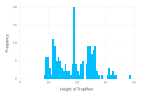

In [4]:
plot(ouvrages, x=:TP_Z, Geom.histogram(bincount=50), Guide.xlabel("Height of TropPlein"),Guide.ylabel("Frequency"))

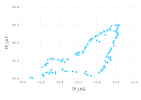

In [5]:
plot(ouvrages,x=:TP_LNG, y=:TP_LAT, Geom.point)

<a id="data_processing_surverse"></a>
### 3.2 Chargement des données de surverse

Ici nous chargeons les données du fichier <i>Surverses.csv</i>. Nous utilisons toutes les colonnes de ce taleau. Ce jeu de donnée provient des données ouvertes de Montréal : http://donnees.ville.montreal.qc.ca/dataset/debordement. Le fichier ne corespond pas tout a fait aux données en ligne. Il y a eu des transformations (jointure) approtées par notre professeur. Le fichier est structuré comme ceci : <br>


**NO_Ouvrage** : (String) L'idendifiant unique de chacun des ouvrages <br>
**Date** : (Date) La date sous le format yyyy-mm-jj de l'observation <br>
**Surverse** : (Bool) Si l'ouvrage a surversé <br>
**Raison** : (String) Abréviation de la raison de la surverse. Les options sont variables, Ex :<br>
- "U" : Urgence;
- "TS" : Déversement par temps sec;
- "P" : Débordement du à la pluie; 
- "N" : Rejet à la rivière des Prairies;
- "S" : Rejet au fleuve St-Laurent;

Au final, nous gardons que les trois premières colonnes. La colonne NO_Ouvrage sera renommé afin de servir de clé externe pour se joindre à la table des ouvrages créés plus haut. De plus, nous allons gardé que les raisons dû à la pluie, débordement par temps sec et ceux inconnus que nous prendrons pour aquis que ce sont des surverses dû à la pluie.

#### Chargement du fichier surverses.csv

In [6]:
surverses = CSV.read("data/surverses.csv", missingstring="-99999");
first(shuffleDf(surverses),5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,4560-03D,2014-07-28,0,missing
2,0801-05D,2016-04-05,0,missing
3,4620-02D,2016-01-19,0,missing
4,4720-01D,2016-10-09,0,missing
5,3480-05D,2015-05-15,missing,missing


┌ Warning: `T` is deprecated, use `nonmissingtype` instead.
│   caller = compacttype(::Type, ::Int64) at show.jl:39
└ @ DataFrames /home/maxg/.julia/packages/DataFrames/XuYBH/src/abstractdataframe/show.jl:39


#### Garder les mois qui nous concerne. (mai à octobre inclusivement)

In [7]:
surverses = filter(row -> month(row.DATE) > 4, surverses);
surverses = filter(row -> month(row.DATE) < 11, surverses);

#### Garder les raisons de surverse qui nous intéresse. (Pluie, Inconnue, TS)

In [8]:
raison = coalesce.(surverses[:,:RAISON],"Inconnue");
surverses[!,:RAISON] = raison;

surverses = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], surverses);
select!(surverses, [:NO_OUVRAGE, :DATE, :SURVERSE]);

#### Retirer les données manquantes ainsi que renommer la colonne NO_OUVRAGE en ID_OUVRAGE

In [9]:
surverses = dropmissing(surverses, disallowmissing=true);
rename!(surverses, :NO_OUVRAGE => :ID_OUVRAGE);
first(shuffleDf(surverses), 5)

,ID_OUVRAGE,DATE,SURVERSE
,String,Date,Int64
1,3230-01D,2015-10-31,0
2,4370-02D,2014-09-12,0
3,4710-02D,2015-08-17,0
4,3350-06D,2013-10-08,0
5,4790-01D,2014-05-11,0


<a id="data_processing_precipitation"></a>
### 3.3 Chargement des données de précipitation

Ici nous chargeons les données du fichier <i> Precipitation.csv </i>. Nous devons effectuer des fonctions d'aggrégation sur ce tableau avant de pouvoir l'intégré dans notre jeu de donnée de nos modèles. En effet, ce tableau contient les données de précipitation par heure pour chacune des cinqs stations météorologiques près de montréal. Cependant, notre jeu de données des features est seulement par jour. Nous allons donc applique 3 fonctions d'aggrégation différente, soit : Somme, Maximum et Maximum3h. 

Ce jeu de données a été préparé par notre professeur à partir des données météos d'environnement Canada :
https://climat.meteo.gc.ca/climate_data/hourly_data_f.html?hlyRange=2008-01-08%7C2019-11-12&dlyRange=2002-12-23%7C2019-11-12&mlyRange=%7C&StationID=30165&Prov=QC&urlExtension=_f.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2019&selRowPerPage=25&Line=17&searchMethod=contains&Month=11&Day=12&txtStationName=montreal&timeframe=1&Year=2019.

Ce jeu de données contient la date sous le format yyyy-mm-jj, l'heure, ainsi que la quantité de pluie au dixième de millimètre pour chacune des cinqs stations météo suivante :
- McTavish (7024745)
- Ste-Anne-de-Bellevue (702FHL8)
- Montreal/Pierre Elliott Trudeau Intl (702S006)
- Montreal/St-Hubert (7027329)
- L’Assomption (7014160)

Les dates contenues dans ce dataset comprennent les années 2013 à 2019. Par contre, nous devons entraîner notre modèle sur les années avant 2019, et prédire sur toute l'année 2019 (de mai à octobre). Il est donc important de noter que cette table contient des données de l'ensemble d'entraînement et de test.

In [10]:
precipitations = CSV.read("data/precipitations.csv",missingstring="-99999");
rename!(precipitations, Symbol("St-Hubert")=>:StHubert);

#### Garder les mois qui nous concerne. (mai à octobre inclusivement)

In [11]:
precipitations = filter(row -> month(row.date) > 4, precipitations);
precipitations = filter(row -> month(row.date) < 11, precipitations);
first(shuffleDf(precipitations),5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2018-10-30,17,0,0,0,0,0
2,2014-10-06,9,0,0,0,0,0
3,2016-07-30,22,0,0,0,0,0
4,2015-08-11,9,71,42,50,54,63
5,2018-09-28,17,0,0,0,0,0


#### Imputation des données de précipitation manquante par la moyenne de la journée de la station concernée

Nous avons commencé par remplacer les valeurs manquantes des précipitations par 0. 0 ici n'était pas farfelu. Le problème est que la grande majorité des colonnes ont des valeurs de 0. De plus, il arrivait qu'il y avait des valeurs manquantes entre deux valeurs de précipitation non-nulle. Il nous semblait alors plus logique d'y mettre la valeur moyenne journalière que de tout simplement mettre 0. Si par contre il adevenais qu'une journée entière soit manquante, alors 0 sera mis comme valeur manquante sur la journée entière, puisque c'est notre cas de figure le plus fréquent.

In [12]:
precipitation_by_day = by(precipitations, :date,  
                            McTavish = :McTavish=>mean_wo_missing, 
                            Bellevue = :Bellevue=>mean_wo_missing, 
                            Assomption = :Assomption=>mean_wo_missing,
                            Trudeau = :Trudeau=>mean_wo_missing,
                            StHubert = :StHubert=>mean_wo_missing)

for i=1:size(precipitations,1)
    if isequal(precipitations[i, :McTavish], missing)
        precipitations[i,:McTavish] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:McTavish][1]
    end
    if isequal(precipitations[i, :Bellevue], missing)
        precipitations[i,:Bellevue] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:Bellevue][1]
    end
    if isequal(precipitations[i, :Assomption], missing)
        precipitations[i,:Assomption] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:Assomption][1]
    end
    if isequal(precipitations[i, :Trudeau], missing)
        precipitations[i,:Trudeau] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:Trudeau][1]
    end
    if isequal(precipitations[i, :StHubert], missing)
        precipitations[i,:StHubert] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:StHubert][1]
    end
end

first(shuffleDf(precipitations), 5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2017-07-15,3,0,4,20,0,0
2,2013-10-04,6,0,0,0,0,0
3,2016-06-23,8,0,0,0,0,0
4,2015-09-15,13,0,0,0,0,0
5,2016-10-28,3,9,21,0,5,10


#### 3.3.1 Aggrégation des précipitations

Cette sous-section aggrégera les données de précipitation selon 3 fonctions différentes : Somme, Maximum et maximum sur 3 heures consécutives. Une visualiation des transformations accompagnera chacune d'entre-elle. Chaque transformation créera un tableau qui sera reprit dans la [section 3.4](#data_processing_join). 

##### 3.3.1.1 Somme des précipitations par jour par station météo

In [13]:
pcp_sum = by(precipitations, :date,  
            McTavish = :McTavish=>sum, 
            Bellevue = :Bellevue=>sum,
            Assomption = :Assomption=>sum, 
            Trudeau = :Trudeau=>sum, 
            StHubert = :StHubert=>sum);
first(shuffleDf(pcp_sum), 5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2013-08-20,0,0,0,0,0
2,2019-07-08,0,0,0,0,0
3,2013-07-12,10,0,0,0,0
4,2018-10-23,0,0,0,0,2
5,2015-06-25,2,2,0,2,0


##### Visualisation des précipitations par station météo

Il y a beaucoup d'élément sur ce graphique. Une particularité de Gadfly est qu'il nous permet de choisir les séries à afficher. On peut cliquer sur les couleurs disirées en légende et réduire l'information affiché ! On peut remarquer sur ce graphique que les stations ont un comportement similaire, mais pas identique. Si nous prennons McTavish et Assomption pour l'année 2016, nous pouvons voir que certain pic de précipitations ne sont pas idendique.

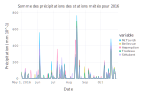

In [26]:
df_for_plot = pcp_sum
df_for_plot = filter(row -> year(row.date) == 2016, pcp_sum);
df_for_plot = melt(df_for_plot, :date)
plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable, Guide.title("Somme des précipitations des stations météo pour 2016"), Guide.xlabel("Date"), Guide.ylabel("Précipitation (mm 10^-1)"))

##### 3.3.1.2 Maximum des précipitations par jour par station météo

In [19]:
pcp_max = by(precipitations, :date,  
            McTavish = :McTavish=>maximum,
            Bellevue = :Bellevue=>maximum, 
            Assomption = :Assomption=>maximum,
            Trudeau = :Trudeau=>maximum,
            StHubert = :StHubert=>maximum)
first(shuffleDf(pcp_max),5)

┌ Warning: `T` is deprecated, use `nonmissingtype` instead.
│   caller = groupreduce_init(::typeof(max), ::Nothing, ::Array{Union{Missing, Int64},1}, ::GroupedDataFrame{DataFrame}) at grouping.jl:560
└ @ DataFrames /home/maxg/.julia/packages/DataFrames/XuYBH/src/groupeddataframe/grouping.jl:560


,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2017-05-02,0,0,20,0,0
2,2013-08-25,10,0,20,4,0
3,2017-07-29,0,0,0,0,0
4,2017-05-15,2,5,0,5,5
5,2013-10-24,0,0,0,0,0


##### Visualisation des précipitations par station météo

On peut voir sur ce graphique qu'il nous apporte une information différente sur les précipitations. Puisque la fonction d'aggrégation est différente, l'allure générale du graphique l'est aussi. On peut remarqué qu'il y a des pics plus prononcé à la station Assomption, tandis qu'à celle de StHubert, celà semble moins commun de tomber énormement de pluie en 1 heure en 2014. De plus, nous pouvons voir que nous n'avons aucune donnée pour mai 2014 à la station de StHubert.

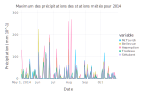

In [27]:
df_for_plot = pcp_max
df_for_plot = filter(row -> year(row.date) == 2014, pcp_max);
df_for_plot = melt(df_for_plot, :date)
plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable, Guide.title("Maximum des précipitations des stations météo pour 2014"), Guide.xlabel("Date"), Guide.ylabel("Précipitation (mm 10^-1)"))

##### 3.3.1.3 Maximum de précipitation durant 3 heures consécutives par heure par station météo

In [23]:
pcp_max3h = by(precipitations, :date,
                McTavish = :McTavish=>maximum3,
                Bellevue = :Bellevue=>maximum3,
                Assomption = :Assomption=>maximum3,
                Trudeau = :Trudeau=>maximum3,
                StHubert = :StHubert=>maximum3)
first(shuffleDf(pcp_max3h),5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2013-06-19,0,0,0,0,0
2,2013-10-28,28,11,10,15,0
3,2017-10-30,38,25,60,31,17
4,2015-08-24,0,0,0,0,37
5,2019-07-17,0,0,128,0,0


##### Visualisation des précipitations par station météo

Il n'y a rien de plus à remarquer que sur les deux autres graphiques.

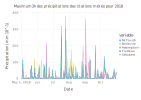

In [37]:
df_for_plot = pcp_max3h
df_for_plot = filter(row -> year(row.date) == 2018, pcp_max3h);
df_for_plot = melt(df_for_plot, :date)
plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable, Guide.title("Maximum3h des précipitations des stations météo pour 2018"), Guide.xlabel("Date"), Guide.ylabel("Précipitation (mm 10^-1)"))

#### 3.3.2 Visualisation des précipitation aggégrés d'une station pour une année

Sur ce graphique, on peut remarquer la corrélation entre les différentes fonctions d'aggrégations. C'était prévisible puisque ce sont des fonctions qui proviennent des mêmes plages de données. De plus, on peut bien voir l'amplitude différentes de chacun de ces features. 

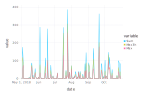

In [30]:
date_to_pt = 2018;
loc = :McTavish
mct_sum = pcp_sum[:,[1,2]]
rename!(mct_sum, loc => :Sum);
mct_sum = filter(row -> year(row.date) == date_to_pt, mct_sum);

mct_max = pcp_max[:,[1,2]]
rename!(mct_max,loc => :Max);
mct_max = filter(row -> year(row.date) == date_to_pt, mct_max);

mct_max3h = pcp_max3h[:,[1,2]]
rename!(mct_max3h,loc => :Max3h);
mct_max3h = filter(row -> year(row.date) == date_to_pt, mct_max3h);

df_for_plot = join(mct_sum, mct_max3h, on = :date);
df_for_plot = join(df_for_plot, mct_max, on = :date);
df_for_plot = melt(df_for_plot, :date)


plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

<a id="data_processing_join"></a>
### 3.4 Jointure des Dataframes

#### Chargement de l'ensemble de test et jointure de ouvrages et surverses

In [29]:
X_test = CSV.read("data/test.csv"); #NO_OUVRAGE, DATE
rename!(X_test, :NO_OUVRAGE => :ID_OUVRAGE);

X_test = join(ouvrages, X_test, on =:ID_OUVRAGE);
features = join(ouvrages, surverses, on =:ID_OUVRAGE);

srv = filter(row -> row.SURVERSE == 1, features);
first(shuffleDf(srv), 10)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,SURVERSE
,String,Float64,Float64,Float64,Date,Int64
1,4330-01D,45.5438,-73.5353,14.16,2016-07-18,1
2,4370-01D,45.4713,-73.5596,19.3526,2015-09-07,1
3,3350-06D,45.5551,-73.6735,21.31,2017-10-09,1
4,4370-01D,45.4713,-73.5596,19.3526,2014-06-13,1
5,4370-03D,45.4367,-73.7095,26.23,2018-05-01,1
6,4420-01D,45.4435,-73.5766,16.86,2014-05-17,1
7,3310-01D,45.6139,-73.6313,19.58,2016-10-21,1
8,4230-05D,45.6728,-73.4915,11.55,2018-09-21,1
9,3370-01D,45.5653,-73.6631,18.21,2016-06-05,1


#### Visualisation des stations en surverse et en non-surverse à une date donnée

Ce graphique est très intéressant, puisqu'il illustre l'état de tous les ouvrages à une date donnée. Il est très intéressant de voir quels ouvrages ont été en surverse et ceux qu'ils ne l'ont pas été. 

In [ ]:
# df_for_geo_plot = filter(row -> row.DATE == Date(2018,7,25), features)
df_for_geo_plot = filter(row -> row.DATE == Date(2015, 5, 30), features)
# df_for_geo_plot = filter(row -> row.DATE == Date(2017, 10, 9), features)
df_for_geo_plot[:SURVERSE] = convert(Array{Bool,1}, df_for_geo_plot[:SURVERSE])
plot(df_for_geo_plot, x=:TP_LNG, y=:TP_LAT, Geom.point, color=:SURVERSE, Guide.title("2018-07-25, état des surverses"))
#first(df_for_geo_plot,5) 

#### Préparation afin d'assigner les données de précipitations aux ouvrages

In [31]:
station_df = DataFrame(STATION = String[], LAT = Float64[], LNG = Float64[]);

push!(station_df, ["McTavish",   45.504742, -73.579167]);
push!(station_df, ["Bellevue",   45.427222, -73.929167]);
push!(station_df, ["Assomption", 45.809444, -73.434722]);
push!(station_df, ["Trudeau",    45.467778, -73.741667]);
push!(station_df, ["StHubert",   45.517500, -73.416944]);

station_df

,STATION,LAT,LNG
,String,Float64,Float64
1,McTavish,45.5047,-73.5792
2,Bellevue,45.4272,-73.9292
3,Assomption,45.8094,-73.4347
4,Trudeau,45.4678,-73.7417
5,StHubert,45.5175,-73.4169


#### Ajout de colonnes vides dans les jeux de données

In [32]:
function addColsForPrecipationPerDay(df)
    df[!, :PCP_SUM] = zeros(size(df, 1));
    df[!, :PCP_MAX] = zeros(size(df, 1));
    df[!, :PCP_MAX3] = zeros(size(df, 1));
    df[!, :METEO] = fill("", size(df, 1));
    return df
end

X_test = addColsForPrecipationPerDay(X_test)
permutecols!(X_test, [:ID_OUVRAGE, :TP_LAT, :TP_LNG, :TP_Z, :DATE, :METEO, :PCP_SUM, :PCP_MAX, :PCP_MAX3]);
    
features = addColsForPrecipationPerDay(features)
permutecols!(features, [:ID_OUVRAGE, :TP_LAT, :TP_LNG, :TP_Z, :DATE, :METEO, :PCP_SUM, :PCP_MAX, :PCP_MAX3, :SURVERSE]);

first(shuffleDf(features), 5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX,PCP_MAX3
,String,Float64,Float64,Float64,Date,String,Float64,Float64,Float64
1,3290-01D,45.6238,-73.6219,19.85,2018-05-09,,0.0,0.0,0.0
2,3350-01D,45.5896,-73.6519,15.09,2017-08-26,,0.0,0.0,0.0
3,0672-03D,45.6732,-73.5402,9.99,2013-05-30,,0.0,0.0,0.0
4,4790-01D,45.4891,-73.5419,14.22,2014-06-19,,0.0,0.0,0.0
5,3350-11D,45.5328,-73.7065,25.28,2013-08-12,,0.0,0.0,0.0


#### Jointure des précipitations aggrégés aux jeux de données basé sur la station météo la plus près de l'ouvrage concerné

In [33]:
function fillPrecipitationWithClosestMeteoStation(df)
    for i=1:size(df, 1)
        id_ouvrage = df[i, 1]; 
        closest_station = "McTavish"; # initial value
        shortest_dist = -1;

        # Find closest station
        for j=1:size(station_df, 1)
            dist = findDistance(df[i, :TP_LAT], df[i, :TP_LNG], station_df[j, :LAT], station_df[j, :LNG]);

            if shortest_dist == -1 || dist < shortest_dist
                shortest_dist = dist;
                closest_station = station_df[j, :STATION];
            end
        end

        # Augment comb with a weighted p_sum, based on the distance to the station
        p_sum = pcp_sum[∈([df[i, :DATE]]).(pcp_sum.date), Symbol(closest_station)];
    #     comb[i, :PCP_SUM] = p_sum[1] * (1 - shortest_dist);
        df[i, :PCP_SUM] = p_sum[1]; 

        # Augment comb with a weighted p_max, based on the distance to the station
        p_max = pcp_max[∈([df[i, :DATE]]).(pcp_max.date), Symbol(closest_station)]
    #     comb[i, :PCP_MAX] = p_max[1] * (1 - shortest_dist);
        df[i, :PCP_MAX] = p_max[1];

        # Augment comb with a weighted p_max3h, based on the distance to the station
        p_max3 = pcp_max3h[∈([df[i, :DATE]]).(pcp_max3h.date), Symbol(closest_station)]
    #     comb[i, :PCP_MAX3] = p_max3[1] * (1 - shortest_dist);
        df[i, :PCP_MAX3] = p_max3[1]; 

        df[i, :METEO] = closest_station
    end
    return df
end

fillPrecipitationWithClosestMeteoStation (generic function with 1 method)

In [34]:
X_test = fillPrecipitationWithClosestMeteoStation(X_test)
features = fillPrecipitationWithClosestMeteoStation(features)
first(shuffleDf(features), 5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX
,String,Float64,Float64,Float64,Date,String,Float64,Float64
1,4430-06D,45.4304,-73.6655,23.67,2016-07-24,Trudeau,0.0,0.0
2,4340-03D,45.5207,-73.5481,18.46,2013-07-07,McTavish,138.0,126.0
3,3540-02D,45.4751,-73.8727,26.52,2014-05-05,Bellevue,0.0,0.0
4,3530-01D,45.5056,-73.8627,27.05,2013-09-14,Bellevue,0.0,0.0
5,3350-05D,45.5705,-73.6624,21.27,2018-08-15,McTavish,12.0,10.0


#### Retrait des données extrêmes de précipitation. Purement subjectif.

In [35]:
X_test[X_test[:PCP_SUM] .> 750, :PCP_SUM] = 750;
X_test[X_test[:PCP_MAX] .> 500, :PCP_MAX] = 500;
X_test[X_test[:PCP_MAX3] .> 750, :PCP_MAX3] = 750;

features[features[:PCP_SUM] .> 750, :PCP_SUM] = 750;
features[features[:PCP_MAX] .> 500, :PCP_MAX] = 500;
features[features[:PCP_MAX3] .> 750, :PCP_MAX3] = 750;

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[35]:1
└ @ Core In[35]:1
┌ Warning: implicit broadcasting in setindex! is deprecated; use `df[row_inds, col_ind] .= Ref(v)` broadcasting assignment to change the column in place
│   caller = setindex!(::DataFrame, ::Int64, ::BitArray{1}, ::Symbol) at deprecated.jl:1490
└ @ DataFrames /home/maxg/.julia/packages/DataFrames/XuYBH/src/deprecated.jl:1490
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[35]:2
└ @ Core In[35]:2
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[35]:3
└ @ Core In[35]:3
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[35]:4
└ @ Core In[35]:4
┌ Warning: `getindex(

#### Visualisation des stations et leur station météo associée

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[36]:2
└ @ Core In[36]:2
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[36]:2
└ @ Core In[36]:2


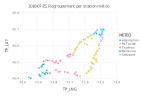

In [36]:
df_for_geo_plot = filter(row -> row.DATE == Date(2018,7,25), features)
df_for_geo_plot[:SURVERSE] = convert(Array{Bool,1}, df_for_geo_plot[:SURVERSE])
plot(df_for_geo_plot, x=:TP_LNG, y=:TP_LAT, Geom.point, color=:METEO, Guide.title("2018-07-25, Regroupement par station météo"))
#first(df_for_geo_plot,5) 

#### Ouvrage 3350-07D pour 2018, quand il surverse, basé sur le critère max3h de pluie tombé.

In [ ]:

# 3260-01D dans Rivière-des-Prairies
# 3350-07D dans Ahunstic
# 4240-01D dans Pointe-aux-Trembles
# 4350-01D dans le Vieux-Montréal
# 4380-01D dans Verdun

id_ouvrage_to_show = "3350-07D"
df_temp = filter(row -> row.ID_OUVRAGE ∈ [id_ouvrage_to_show], features)
df_temp = filter(row -> year(row.DATE) == 2018, df_temp);
df_temp = df_temp[!,[:ID_OUVRAGE, :DATE, :PCP_MAX3, :SURVERSE]]
df_temp[:SURVERSE] = convert(Array{Bool,1}, df_temp[:SURVERSE])



plot(df_temp, x=:DATE, y=:PCP_MAX3, Geom.point, color=:SURVERSE,Guide.title(id_ouvrage_to_show))
#first(shuffleDf(df_temp), 10)

#### Ajout de colonnes Mois (MONTH) et Jour (DAY)

In [ ]:
function splitDateByMonthAndDay(df)
    df[!,:MONTH] = month.(df.DATE);
    df[!,:DAY] = day.(df.DATE);
    return df
end

X_test = splitDateByMonthAndDay(X_test)
features = splitDateByMonthAndDay(features)
first(shuffleDf(features[!, [:DATE, :MONTH, :DAY]]), 5)

#### Déclaration de fonctions utilitaires

C'est fonction seront utiles dans les section [3.5](#data_processing_std_oh) et [3.6](#data_processing_validation)

In [ ]:
function partitionTrainTest(data, at = 0.8) # https://discourse.julialang.org/t/simple-tool-for-train-test-split/473/2
    n = nrow(data)
    idx = shuffle(1:n)
    train_idx = view(idx, 1:floor(Int, at*n))
    test_idx = view(idx, (floor(Int, at*n)+1):n)
    return data[train_idx,:], data[test_idx,:]
end


In [ ]:
function standarizeTrainTestCol(X_train, X_test, col)
    mean_train_col = mean(X_train[!, col]);
    std_train_col = std(X_train[!, col]);
    X_train[!, col] = (X_train[!, col] .- mean_train_col) ./ std_train_col;
    X_test[!, col] = (X_test[!, col] .- mean_train_col) ./ std_train_col;
    
    return X_train, X_test
end
    

In [ ]:
function oneHotMeteoStation(df, col)
    df[!, :S_1] = zeros(size(df, 1));
    df[!, :S_2] = zeros(size(df, 1));
    df[!, :S_3] = zeros(size(df, 1));
    df[!, :S_4] = zeros(size(df, 1));
    df[!, :S_5] = zeros(size(df, 1));
    
    categories = ["Assomption", "McTavish", "Trudeau", "Bellevue", "StHubert"]
    one_hot_cols = [:S_1, :S_2, :S_3, :S_4, :S_5]
    
    for i=1:size(df,1)
        for j=1:size(categories,1)
            if df[i, col] ∈ [ categories[j] ]
                df[i, one_hot_cols[j]] = 1
            end
        end
    end
    return df
end

<a id="data_processing_std_oh"></a>
### 3.5 Standardization et OneHot des colonnes

Nous devons effectuer ces opérations puisqu'en règle générale, les algorithmes de machine learing fonctionne mieux avec des données entre 0 et 1. De plus, il est primordiale pour la colonne :METEO d'être encodé sous ce format comme pour les colonnes sous format float, elle serait incompréhensible.

**Standardisation** : $ \bf{X}_{ij} = \frac{\bf{X}_{ij}-\bar{x}_i}{\sigma^2_{X_i}}$, où i est l'index de la colonne désirée et j l'index de la ligne désirée. Il est a noté que les paramètres $\bar{X_i}$ et $\sigma^2_{X_i}$ sont calculés et utilisés sur l'ensemble d'entraînement, mais seulement utilisé sur l'ensemble de test. C'est-à-dire que les données de test ne sont pas pris en compte dans les calcules de ces paramètres. Cette opération recentre la distribution en 0.

**OneHot** : Le OneHot est le principe de transformer une variable catégorielle en plusieurs colonnes binaires. Ex : 

|A|>|A_1|A_2|
|:---:|:---:|:---:|:---:|
|"a"|>|1|0|
|"b"|>|0|1|
|"a"|>|1|0|

Il y a deux écoles de pensé dans cette technique. La première est de représenter la première catégorie avec que des 0. Dans l'exemple ci-haut, "a" aurait la valeur A_1=0 et A_2=0. Si nous avons $n$ catégories, nous avons besoin alors de $n-1$ colonnes pour représenter toutes ces catégories. La deuxième école de pensé est la suivante : 1 colonne par catégorie. Si nous avons $n$ catégories, nous avons besoin alors de $n$ colonnes. Nous pouvons donc réserver le 0,...,0 pour des cas inconnus du OneHot. Nous avons opté pour la deuxième école de penser, mais si nous n'exploitons pas l'avantage de celle-ci sur le premier cas énnoncé.

In [ ]:
X_train = features

X_train = oneHotMeteoStation(X_train, :METEO)
X_test = oneHotMeteoStation(X_test, :METEO)

X_train, X_test = standarizeTrainTestCol(X_train, X_test, :TP_LAT)
X_train, X_test = standarizeTrainTestCol(X_train, X_test, :TP_LNG)
X_train, X_test = standarizeTrainTestCol(X_train, X_test, :TP_Z)
X_train, X_test = standarizeTrainTestCol(X_train, X_test, :PCP_SUM)
X_train, X_test = standarizeTrainTestCol(X_train, X_test, :PCP_MAX)
X_train, X_test = standarizeTrainTestCol(X_train, X_test, :PCP_MAX3)
X_train, X_test = standarizeTrainTestCol(X_train, X_test, :MONTH)
X_train_all, X_test = standarizeTrainTestCol(X_train, X_test, :DAY)

first(shuffleDf(X_test), 5)

<a id="data_processing_validation"></a>
### 3.6 Création de l'ensemble de validation

Une technique extrêmement commune dans le domaine des sciences des données est de séparer l'ensemble d'entraînement afin de se créer un ensemble de validation. L'intérêt de faire ceci est que l'on sait les réponses sur l'ensemble de validation. Nous pouvons donc être en mesure de faire un évalutaion sommaire d'un modèle sur cette partie du dataset. Il est donc cruciale que cette partie ne soit pas pris en compte dans l'entraînement. Il n'est pas recommandé de valider et de s'entraîner sur les mêmes données. On pourrait courrir le risque d'avoir un phénomène de surapprentissage et biaiser notre évaluation sommaire.

In [ ]:
X_train, X_val = partitionTrainTest(X_train_all, 0.8)

first(shuffleDf(X_train), 5)

In [ ]:
first(shuffleDf(X_val), 5)

In [ ]:
#first(shuffleDf(X_val[!,[:METEO,:S_1,:S_2,:S_3,:S_4,:S_5]]),5)

### 3.7 Conclusion

Dans cette section nous avons créé nos trois dataframes important à la construction de nos différents modèles. Nous avons construit ces dataframes grâce à nos trois sources de données sur les ouvrages, les surverses ainsi que les précipitaions par jour. De plus, nous avons appliqué des transformations sur certaines colonnes afin de créer d'autres features pouvant être utilisé par nos modèles par la suite. Il est vrai que nous avons fait une certaine analyse exploratoire au fur et à mesure de cette section, mais il aurait été intéressant d'en faire une plus en profondeur. Quelles ouvrages / regions sont les plus propices à la surverse ? Est-ce qu'il y a un lien avec la hauteur du trop-plein ? Est-ce que avoir une animation de chaque jour et l'état des surverses pourrait nous donner de l'information additionnel ?

## Chargement des données

<a id="data_analysis"></a>

## 4. Analyse exploratoire




<a id="naive-bayes"></a>
### 4.2 Régression bayésienne naïve


#### 4.2.1 Définition des fonctions d'aide

Ici nous définissons une fonction permettant de trouver la meilleure distribution qui s'ajuste le mieux pour un ensemble de données. Pour faire cela, nous testons plusieurs distributions différentes sur notre ensemble de données. Pour testé chacune de ces distributions, nous faisons appel à la librairie de Julia "fit" qui permet d'ajuster une distribution sur un ensemble de données. Par la suite, nous calculons la log vraisemblance de cette distribution. Nous ne conservons seulement que la distribution ayant la logvraisemblance la plus élevée.

In [ ]:
#= fonction qui trouve la distribution qui représente le mieux un ensemble de donnée=#

function fitBestLikelihoodDistribution(data::Array, verbose::Bool)
    # Définition des distributions à essayer
    distributions = [Beta, Binomial, 
              Categorical, DiscreteUniform, Exponential, 
              Normal, Gamma, Geometric, Laplace, Pareto, 
              Poisson, Uniform, Multinomial, MvNormal, Dirichlet, Weibull];
    
    distributionNames = ["Beta", "Binomial", 
                  "Categorical", "DiscreteUniform", "Exponential", 
                  "Normal", "Gamma", "Geometric", "Laplace", "Pareto", 
                  "Poisson", "Uniform", "Multinomial", "MvNormal", "Dirichlet", "Weibull"];
    
    # Déclaration des variables
    maxLikelihood = -Inf;
    distributionName = nothing;
    finalFitDistribution = nothing;
    fitDistribution = nothing;
    
    for i = 1:length(distributions) # Pour chaque type de distribution
        if (verbose)
            println("Trying model of type: ", distributionNames[i]);
        end
        try # On essaie de faire fit la distribution sur les données
            fitDistribution = fit(distributions[i], data);
        catch
            if (verbose)
                println("Invalid");
            end
            continue
        end
        
        newLikelihood = loglikelihood(fitDistribution, data)
        
        # Si on trouve une meilleure logvraisemblance que celle qu'on a déjà, 
        # la distribution courante est le meilleure
        if (newLikelihood > maxLikelihood) 
            maxLikelihood = newLikelihood;
            distributionName = distributionNames[i];
            finalFitDistribution = fitDistribution;
        end
    end
    
    println("The best distribution is of type ", distributionName, " with a likelihood of ", maxLikelihood)
    return finalFitDistribution;
end

Ici nous définissons une fonction permettant de retrouver les meilleures distributions pour chacunes de nos variables explicatives sélectionnées. Pour chacune d'entre elles, nous devons trouver la meilleure distribution sachant la classe final. Dans notre cas, nous trouvons donc, pour chaque variable explicative, la meilleure distribution pour les exemplaires où il n'y a pas de surverse et une pour les exemplaires où il y a surverse. 

In [ ]:
#= Cette fonction retourne un tableau des meilleurs distributions selon les variables explicatives données 
(une distribution lorsqu'il n'y a pas de surverse et 
une distribution lorsqu'il y a surverse pour chaque variabe explicative)=#

function getBestLikelihoodDistributions(train::DataFrame, variable::Symbol)
    x_m = [];
    for i=0:1
        ind = train[:,:SURVERSE] .== i;
        x=train[ind,variable];
        push!(x_m,fitBestLikelihoodDistribution(x, false));
    end
    
    return x_m;
end

Ici nous définissons une fonction permettant de récuperer une loi a priori en se basant sur un ensemble de données. Puisque notre prédiction est soit surverse ou non, notre loi a priori est donc une loi de Bernoulli où nous pouvons trouver la probabilité de succès en selon l'ensemble de données passé en paramètre.

In [ ]:
#=fonction permettant de récupérer un a priori en se basant sur la distribution d'un ensemble de données. =#
function getPrioris(trainSet::DataFrame)
    dAlpha = trainSet[:,:SURVERSE];
    n_mode = Float64[];
    for i=0:1
        push!(n_mode, count(dAlpha .== i));
    end
    α = n_mode/size(trainSet,1);
    
    return α;
end

### 4.2.2 Prédiction bayesien naïf

Ici nous définissons la fonction permettant d'effectuer un prédiction sur les données fournies en paramètres à l'aide des distributions et de la loi a priori aussi fournies en paramètres. Si nous étions capable de trouver une loi a posteriori de façon analytique, nous effecturions la prédiction de la façon suivante:
a posteriori = vraisemblance * a priori, ce qui donnerait la formule suivante:

$ f_{\theta | Y}(\theta) = f_{Y | \theta}(y) \dot f_\theta(\theta) $

Toutefois, puisque nous utilisons une approche numérique, la formule ressemble plutôt à celà: 

$ p(C|X) = p(C) \prod_{i=1}^n p(X_i|C)$

Les distributions sachant la classe sont données en paramètres et peuvent donc être utilisé ici directement. La loi a priori est aussi fournies en paramètre. Toutefois, si nous voulions utiliser une loi a priori non informative, il sufirait de remplacer la probabilité par 1 comme la ligne commentée ici le suggère. Cela nous donnerait donc une loi non informative Uniforme(0,1). Finalement, pour déterminer la classe de chaque exemplaire, nous prenons la classe ayant obtenu la plus grande probabilité.

In [ ]:
#= fonction permettant de faire une prédiction sur les données à 
l'aide des distributions et de la loi a priori fourni. =#
function predictNaiveBayes(data::DataFrame, likelihoodDistrs::Array, prioris::Array, variables::Array)
    n_data = size(data,1);
    nb_exp_var = size(variables,1);
    y_m = Array{Int64}(undef,n_data);

    for i=1:n_data
        p = [];
        for j=1:2
#             prob =1; # à priori non informatif (Uniform(0,1))
            prob = prioris[j]
            for k=1:nb_exp_var
                prob *= pdf.(likelihoodDistrs[k][j], data[i,variables[k]]);
            end
            push!(p,prob);
        end
        _, ind = findmax(p);
        y_m[i] =ind -1;
    end
    
    return y_m;
end

### 4.2.3 Sélection du meilleur modèle

Dans cette section, nous explorerons deux approches différentes pour sélectionner le meilleur modèle de classification bayésienne naïve, soient une approche basée sur le BIC, ainsi qu'une approche basée sur le F1-score obtenu sur un ensemble de validation.

Sélectionner le meilleur modèle de classification bayésienne naïve revient à trouver les variables explicatives devant être incluses et excluses pour que le modèle soit le plus précis.

#### 4.2.3.1 Sélection du meilleur modèle à l'aide du BIC

In [ ]:
function BIC(distributions::Dict, data::DataFrame)
    n = size(data)[1]
    k = length(keys(distributions))
    totalLogLikelihood = 0
    for variable in keys(distributions)
        for j=0:1
            ind = data[:,:SURVERSE] .== j;
            x=data[ind,variable];
            totalLogLikelihood += loglikelihood(distributions[variable][j+1], x)
        end
    end
    return (totalLogLikelihood - k*log(n)/2);
end

In [ ]:
function findBestVariablesCombinationBIC(train::DataFrame, likelihoodDistrs::Dict, variables::Array{Symbol})
    bics = []
    bicsDict = Dict()
    combinations = []
    for combination in subsets(variables)
        push!(combinations, combination)
        modelVariables = []
        modelLikelihoodDistrs = Dict()
        for variable in combination
            modelLikelihoodDistrs[variable] = likelihoodDistrs[variable]
        end
        bic = BIC(modelLikelihoodDistrs, train)
        if bic == 0.0
            continue
        end
        push!(bics, bic)
    end
    _, indexMax = findmax(bics)
    println("Best combination: ", combinations[indexMax], " with bic: ", bics[indexMax])
    return (combinations[indexMax], bics[indexMax])
end